# Aim to test various characcteristics of the problem

### Various functions and settings


In [1]:
import numpy as np
from numpy import zeros, eye, array, diag, exp, ones, tanh, cosh, dstack, log, hstack, vstack, sinh
from numpy.linalg import solve, norm
from numpy.random import choice, default_rng, randint, randn
from scipy.stats import multivariate_normal as MVN
from scipy.special import logsumexp, ndtr
from scipy.stats import uniform as udist
import math
import time
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import rc
from ipywidgets.widgets import IntSlider
from ipywidgets.widgets import interact
from warnings import resetwarnings, catch_warnings, filterwarnings
import seaborn as sns

from Manifolds.GKManifoldNew import GKManifold, data_generator, find_point_on_manifold, find_point_on_manifold_from_θ
from markov_snippets import MSAdaptive, SMCAdaptive
from tangential_hug_functions import TangentialHugSampler
from tangential_hug_functions import HugTangentialMultivariate
from RWM import RWM
from utils import ESS_univariate

In [2]:
seed = 1234
m = 20     # number of latent variables
d = m + 4  # dimensionality of x-component

In [154]:
def generate_settings(
    d=d, 
    N=2000,
    B=20,
    δ=0.01,
    δmin=1e-3,
    δmax=100.0,
    εmin=1e-16,
    min_pm=1e-4,
    maxiter=500,
    verbose=False,
    εs_fixed=None,
    adaptiveε=True,
    adaptiveδ=False,
    z0_manual=None,
    pm_target=0.23,
    pm_switch=0.1,
    prior_seed=seed,
    low_memory=True,
    integrator='rwm',
    εprop_switch=0.01,
    ε0_manual=None,
    quantile_value=0.9,
    initialization='manual',
    switch_strategy='pm',
    kernel='uniform',
    prior_scale=7,
    thinning=10,
    burnin=100,
    use_autograd=False,
    stopping_criterion={'εmin', 'pm'},
    resampling_seed=1234,
    mh_kernel_seed=1234,
    resampling_scheme='multinomial',
    prop_hug=0.5,
    projection_method='qr',
    metropolised=False):
    # here d represents m+4
    # Generate the manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=seed)  # Observed data
    q         = MVN(zeros(d), eye(d))             # Proposal distribution for THUG
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type=kernel, use_autograd=use_autograd)
    # grab arguments
    arguments = locals()
    return arguments

In [4]:
def generate_initial_particles(ϵ0, N=5000, s=0.001):
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)

    # Generate target distribution
    ξ0 = manifold.sample()               # Initial point on manifold                            # Starting epsilon
    logηε0 = manifold.generate_logηε(ε0)  # Target filamentary distribution

    # Sample from it using RWM
    s_rwm, a_rwm = RWM(x0=ξ0, s=s, N=N, logpi=logηε0)

    # Add velocities to particles
    v0_manual = randn(*s_rwm.shape)
    z0_manual = np.hstack((s_rwm, v0_manual))
    return z0_manual

def generate_initial_particles_on_manifold(N=5000, θtrue=False):
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Sample N times
    x0_manual = np.vstack([manifold.sample(fromtheta=θtrue) for _ in range(N)])
    v0_manual = randn(*x0_manual.shape)
    return np.hstack((x0_manual, v0_manual))

def generate_particles_on_manifold_then_rwm(ϵ0, N=5000, θtrue=False, δrwm=0.001):
    """First, generate particles on the manifold. Then use RWM to actually sample from a filamentary
    distribution of sorts."""
    # Generate manifold (used only to generate filamentary distribution)
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Sample on manifold
    on_manifold = generate_initial_particles_on_manifold(N=N, θtrue=θtrue)
    x0_on_manifold = on_manifold[:, :on_manifold.shape[1]//2]
    # Store filamentary samples
    filamentary_samples = []
    for x0 in x0_on_manifold:
        filamentary_samples.append(RWM(x0, s=δrwm, N=1, logpi=manifold.generate_logηε(ϵ0))[0].flatten())
    # Create array
    v0_manual = randn(*x0_on_manifold.shape)
    x0_manual = np.vstack(filamentary_samples)
    return np.hstack((x0_manual, v0_manual))

def sample_from_filamentary(ε0, N=2000, n_per_sample=10, s=1.0, fromtheta=False):
    samples = []
    acceptances = []
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Construct filamentary distribution
    logηε0 = manifold.generate_logηε(ε0)
    while len(acceptances) < N:
        with catch_warnings():
            filterwarnings('error')
            try:
                # Sample on the manifold
                ξ0 = manifold.sample(fromtheta=fromtheta)
                # Sample starting from ξ0 and perform 10 steps of RWM. Grab the final point
                s_rwm, a_rwm = RWM(x0=ξ0, s=s, N=n_per_sample, logpi=logηε0)
                samples.append(s_rwm[-1])
                acceptances.append(np.mean(a_rwm)) #int(sum(a_rwm == 1) > 0))
            except RuntimeWarning:
                continue
    print("Acceptance Probability: {:.3f}".format(np.mean(acceptances)*100))
    x0_manual = vstack(samples)
    v0_manual = v0_manual = randn(*x0_manual.shape)
    return hstack((x0_manual, v0_manual))

def sample_from_filamentary_with_thug(ε0, N=2000, n_per_sample=10, s=1.0, fromtheta=False):
    samples = []
    acceptances = []
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Construct filamentary distribution
    logηε0 = manifold.generate_logηε(ε0)
    while len(acceptances) < N:
        with catch_warnings():
            filterwarnings('error')
            try:
                # Sample on the manifold
                ξ0 = manifold.sample(fromtheta=fromtheta)
                # Sample starting from ξ0 and perform 10 steps of RWM. Grab the final point
                THUG = TangentialHugSampler(ξ0, T=5*s, B=5, N=N, α=0.0, logpi=logηε0, jac=manifold.fullJacobian)
                s_thug, a_thug = THUG.sample() #(x0=ξ0, s=s, N=n_per_sample, logpi=logηε0)
                samples.append(s_thug[-1])
                acceptances.append(np.mean(a_thug)) #int(sum(a_rwm == 1) > 0))
            except RuntimeWarning:
                continue
    print("Acceptance Probability: {:.3f}".format(np.mean(acceptances)*100))
    x0_manual = vstack(samples)
    v0_manual = v0_manual = randn(*x0_manual.shape)
    return hstack((x0_manual, v0_manual))


In [5]:
N      = 5000
B      = 20
δmin   = 1e-3
min_pm = 1e-4
pm_switch = 0.1
quantile_value = 0.9

# Ideas

### Prior Initialization

I want to run MS-RWM, MS-HUG, MS-HAN starting from the prior and see what $\varepsilon$s and acceptance probabilities we obtain.

- Seems that MS-RWM with adaptive step size (with small $\delta_{\text{min}}$) can reach fairly small tolerances. Therefore there doesn't necessarily seem to a be an inherent problem of the G-and-K task with reaching small epsilons. More experiments are needed.
- Seems that MS-HUG on its own is quite slow at reaching small epsilons. This makes sense, it is designed to stay close to the current level-set, so the distances of the particles from the manifold don't change much at all. 
    - either I let it go for a very long time
    - or I should accelerate at the beginning and only after switch to HUG or HAN.
- Need to check if HAN on its own with `prop_hug=0.5` is enough to be able to reach small epsilon faster than HUG on its own, and hopefully achieve smaller epsilon than RMW. So far, HAN seems pretty good at keeping a very high AP as it decreases epsilon.
- However, also HAN seems to be slowing down before reaching truly filamentary distributions. Perhaps I need a slightly larger step size. I need to be careful because starting the algorithm from the prior with $\delta=0.1$ leads to overflow error in the Jacobian computation (unsure why). For this reason, I am using $\delta=0.01$, however it might be that something like $\delta=0.05$ might be better. Alternatively, I could try and use adaptive $\delta$ just to see if it is even possible to get to filamentary distributions. One I reach those, it will be interesting to look at the histograms of the indeces.
- MS-HAN with adaptive $\delta$ fails. More specifically, the Jacobian computation fails. Unsure why. Seems that with a large enough step size, that happens. Need to explore that.

### Filamentary Initialization

I want to initialize the particles from $\eta_{\varepsilon_0}$ for some $\varepsilon_0$. Unsure what the correct choice would be. Either way, I need to make sure that the samples are somewhat good.

- One option is to take the final particles and final $\epsilon$ from a run of MS-RWM and run MS-HUG or MS-HAN in manual mode from these particles. Hopefully, one should see that MS-HAN will be able to achieve somewhat small epsilon faster, but MS-HUG should, in theory, be able to achieve smallER epsilons, once it gets there. 

## Prior Initialization

### MS-RWM

##### Step-size=0.01

In [21]:
ms_rwm_001_05 = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.01,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=150))
ms_rwm_001_05_particles = ms_rwm_001_05.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7782000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 496.5262376630601580
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9528000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 90.4798063082705681
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9496000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 42.0483802453594961
	Weights 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8384000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.8976745210781929
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8292000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7493149078347225
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8352000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6071705283548474
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8230000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.4748348900023478
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5106000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5360385649265913
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5012000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5012838424093484
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4856000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4689410989498877
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4700000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4383457036261467
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0840000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  100
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8691071929542744
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0854000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8608275134024960
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0846000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8518078958557177
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0992000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8432457490256796


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0502000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6368497743934258
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0474000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6293213163728787
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0380000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6217188159834935
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0508000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  136
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6134629624052090


##### Step-size=0.1

In [23]:
ms_rwm_01_05 = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.1,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=150))
ms_rwm_01_05_particles = ms_rwm_01_05.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0960000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 598.1570002365729124
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8812000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 94.3808410515471650
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9274000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 46.2778814733262323
	Weights 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1574000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2444945758704522
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1426000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0815461886397029
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1210000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9311956305852269
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1110000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.7810511169888601
	Wei

##### Adaptive step size

In [25]:
ms_rwm_aδ_05 = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.1,
        δmin=1e-5,
        δmax=100.0,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=True,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=500))
ms_rwm_aδ_05_particles = ms_rwm_aδ_05.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0960000000000000
	Step-size adapted to: 0.0935195201336777
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 598.1570002365729124
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9220000000000000
	Step-size adapted to: 0.1321807343869539
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 92.6270679994694888
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7936000000000000
	Step-size adapted to: 0.1752073598660959
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 46.4457216376648603
	Weights computed 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0182000000000000
	Step-size adapted to: 0.0674691317576872
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.8702371263885027
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0476000000000000
	Step-size adapted to: 0.0615881933632459
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.8101125996755569
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0284000000000000
	Step-size adapted to: 0.0556827378507896
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7591207675444056
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0316000000000000
	Step-size adapted to: 0.0504241479330027
Iteration:  38
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7264991046517286
	Weights compute

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1894000000000000
	Step-size adapted to: 0.0101509793243201
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2184758626570700
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1516000000000000
	Step-size adapted to: 0.0097607592166234
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2104682354955938
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1502000000000000
	Step-size adapted to: 0.0093789722237696
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2016096411377961
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2322000000000000
	Step-size adapted to: 0.0093892947695750
Iteration:  72
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.1932879082200420
	Weights compute

	Epsilon: 3.0784023115092825
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1870000000000000
	Step-size adapted to: 0.0041382383832449
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0768498017268389
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2048000000000000
	Step-size adapted to: 0.0040864236976418
Iteration:  104
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0747449790103696
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2490000000000000
	Step-size adapted to: 0.0041254297079611
Iteration:  105
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0719742080530406
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2858000000000000
	Step-size adapted to: 0.0042421498718525
Iteration:  106
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.

	Epsilon: 3.0086572379052665
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1940000000000000
	Step-size adapted to: 0.0029989738674913
Iteration:  137
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0074449150740019
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1732000000000000
	Step-size adapted to: 0.0029150010674313
Iteration:  138
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0064233274728873
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1890000000000000
	Step-size adapted to: 0.0028558518959950
Iteration:  139
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0055196484910507
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2004000000000000
	Step-size adapted to: 0.0028138965235132
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.

	Epsilon: 2.9668266752380750
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2152000000000000
	Step-size adapted to: 0.0028923525033334
Iteration:  171
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9657161213092831
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2006000000000000
	Step-size adapted to: 0.0028501459001009
Iteration:  172
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9646991242651159
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2132000000000000
	Step-size adapted to: 0.0028263049467288
Iteration:  173
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9635916646270881
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1922000000000000
	Step-size adapted to: 0.0027733894102096
Iteration:  174
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.

	Epsilon: 2.9111689320531795
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2994000000000000
	Step-size adapted to: 0.0037306041311186
Iteration:  205
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9087096772389400
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2918000000000000
	Step-size adapted to: 0.0038476792948195
Iteration:  206
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9061518275553393
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2996000000000000
	Step-size adapted to: 0.0039839356440425
Iteration:  207
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9034445879811321
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3112000000000000
	Step-size adapted to: 0.0041490118024172
Iteration:  208
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.

	Epsilon: 2.7192402609392010
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1908000000000000
	Step-size adapted to: 0.0063380438890233
Iteration:  239
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.7144794160673689
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2114000000000000
	Step-size adapted to: 0.0062793733218602
Iteration:  240
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.7087968077008955
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2788000000000000
	Step-size adapted to: 0.0064344745711411
Iteration:  241
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.7017367718014365
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3072000000000000
	Step-size adapted to: 0.0066877011213341
Iteration:  242
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.

	Epsilon: 1.5451216397119216
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2050000000000000
	Step-size adapted to: 0.0180612757673247
Iteration:  273
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5056047383051936
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2180000000000000
	Step-size adapted to: 0.0179532325664528
Iteration:  274
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4708486026321927
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1600000000000000
	Step-size adapted to: 0.0173357386054986
Iteration:  275
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4392037733191767
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1664000000000000
	Step-size adapted to: 0.0167931352358367
Iteration:  276
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.

	Epsilon: 0.7485466469003135
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1868000000000000
	Step-size adapted to: 0.0093611690948726
Iteration:  307
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7301548276845939
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2028000000000000
	Step-size adapted to: 0.0092347190048062
Iteration:  308
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7117803200064978
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1904000000000000
	Step-size adapted to: 0.0090536698697843
Iteration:  309
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6939558401834605
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1776000000000000
	Step-size adapted to: 0.0088195441586300
Iteration:  310
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.

	Epsilon: 0.3497002249126863
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2032000000000000
	Step-size adapted to: 0.0045252380612458
Iteration:  341
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3397223033076377
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2146000000000000
	Step-size adapted to: 0.0044905275351983
Iteration:  342
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3303691614319917
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2058000000000000
	Step-size adapted to: 0.0044365195592177
Iteration:  343
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3212476941081174
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2002000000000000
	Step-size adapted to: 0.0043709054567598
Iteration:  344
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.

	Epsilon: 0.0982431548895237
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0948000000000000
	Step-size adapted to: 0.0018527484513587
Iteration:  375
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0946662186160564
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1040000000000000
	Step-size adapted to: 0.0017396260667909
Iteration:  376
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0913518995171761
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1594000000000000
	Step-size adapted to: 0.0016792884902336
Iteration:  377
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0878340071680581
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1452000000000000
	Step-size adapted to: 0.0016095750273540
Iteration:  378
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.

	Epsilon: 0.0246314787006662
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1112000000000000
	Step-size adapted to: 0.0004526075728628
Iteration:  409
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0238001426449344
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1178000000000000
	Step-size adapted to: 0.0004279153796645
Iteration:  410
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0229819017641762
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1612000000000000
	Step-size adapted to: 0.0004134454011394
Iteration:  411
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0221349024680530
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1616000000000000
	Step-size adapted to: 0.0003995446265480
Iteration:  412
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.

	Epsilon: 0.0076511569618689
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1452000000000000
	Step-size adapted to: 0.0001193577713923
Iteration:  443
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0074201495679223
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1606000000000000
	Step-size adapted to: 0.0001152870914689
Iteration:  444
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0072143013561481
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1410000000000000
	Step-size adapted to: 0.0001102692899958
Iteration:  445
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0070153188894868
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1350000000000000
	Step-size adapted to: 0.0001051539498049
Iteration:  446
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.

	Epsilon: 0.0027122953197167
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1970000000000000
	Step-size adapted to: 0.0000406348253010
Iteration:  477
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0026254471555480
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1742000000000000
	Step-size adapted to: 0.0000395167828904
Iteration:  478
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0025428283825424
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1630000000000000
	Step-size adapted to: 0.0000382148989702
Iteration:  479
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0024599339328713
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1584000000000000
	Step-size adapted to: 0.0000368710048216
Iteration:  480
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.

### MS-HUG

##### Step-size=0.1

In [28]:
ms_hug_01_05 = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.1,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='thug',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=200))
ms_hug_01_05_particles = ms_hug_01_05.sample()

Integrator: THUG.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1798000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 675.7676929938770627
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8954000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 108.1038500114849228
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8734000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 45.9537886319339322
	Weight

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8381999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.1857040371434096
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8308000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.0961414338610780
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8330000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.0229806051861914
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8490000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 12.9539533795525390


	Trajectories constructed.
	Epsilon: 10.8177341454667957
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8431999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.7541706240419508
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8159999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.6939466926584483
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8244000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.6327237137207078
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8238000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  70
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 9.3402579866305793
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8381999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  100
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.3129253264662371
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8310000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.2860370146380138
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8274000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.2600761776151330
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8354000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  103
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 8.7244776582681922
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8396000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.7104306251133714
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8176000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.6957796236231886
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8430000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.6814216915225515
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8456000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  136
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 8.3897195607305086
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8244000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  166
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.3791751539775206
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8408000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  167
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.3689083252288441
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8164000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  168
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.3598011623852653
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8202000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  169
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 8.1372947411803445
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8142000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  199
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.1332738258202291
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9094000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  200
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.1292840123220103
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9534000000000000
	Step-size kept fixed at: 0.1000000000000000


### MS-HAN

##### Step-size=0.01

In [34]:
ms_han_001_05 = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.01,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='hug_and_nhug',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=500,
        prop_hug=0.5))
ms_han_001_05_particles = ms_han_001_05.sample()

Integrator: HUG + NHUG.
Prop Hug  :  0.5
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8474000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 607.4206711711401567
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9532000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 100.6784783233150620
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9588000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 44.9

	Trajectories constructed.
	Epsilon: 7.1199509385595867
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9408000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.7903082378562694
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9322000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.5059838462068829
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9378000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.2636571956762674
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9374000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Tra

	Trajectories constructed.
	Epsilon: 3.9337681273876233
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9170000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.9075280459858690
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9150000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.8789177741146608
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9074000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.8499406148941722
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9118000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Tra

	Trajectories constructed.
	Epsilon: 3.3483167291732197
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9137999999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  100
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.3430663860943461
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9136000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.3373410267525832
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9144000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.3294692426316495
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9102000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  103
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 3.1293797007490785
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8982000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.1253821493489502
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8994000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.1226744034244200
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9008000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.1206887370413998
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8996000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  136
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 2.6395167199692509
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9242000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  166
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.6198155501860896
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9166000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  167
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.6027017279056892
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9196000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  168
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.5727175348720244
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9192000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  169
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 1.7589473778411013
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9238000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  199
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7385230605805448
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9214000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  200
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7085854778864966
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9127999999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  201
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6764813776711989
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9116000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  202
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 1.1404854909983539
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8960000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  232
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1300306949125603
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9064000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  233
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1155559347559456
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9024000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  234
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1001688382125123
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9016000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  235
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.8120805596124687
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9040000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  265
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8049568383931088
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8940000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  266
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7990938924209754
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8884000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  267
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7945654551542642
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8910000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  268
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.5558308343526018
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8942000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  298
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5502121239828637
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8816000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  299
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5451021515386008
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8918000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  300
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5409643891745584
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8826000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  301
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.4213926354076164
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8308000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  331
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4208652200351582
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8352000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  332
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4203181330142594
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8362000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  333
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4195847197775001
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8606000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  334
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.3220473553614622
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8782000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  364
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3188246723126803
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8560000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  365
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3164738885455086
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8464000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  366
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3143097366842116
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8448000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  367
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.2276595973218555
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8274000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  397
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2264021976393941
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8178000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  398
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2254224896929412
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7982000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  399
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2244528533691719
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7934000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  400
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.1750566636083173
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7422000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  430
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1742581094249442
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7476000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  431
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1736378911362133
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7044000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  432
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1732030255752524
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6608000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  433
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.1554391950502547
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6956000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  463
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1549090545401543
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7148000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  464
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1541566236037973
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7148000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  465
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1534872202784363
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7014000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  466
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.1336410404633693
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5246000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  496
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1334285357714159
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5164000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  497
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1332529938987173
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5032000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  498
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1330943671058676
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4958000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  499
	Quantile Value:  0.5


In [42]:
import re
pattern = r'Epsilon: (\d+\.\d+)'
matches = re.findall(pattern, printed_text)
epsilon_values = np.array([float(match) for match in matches])
prop_moved = np.array([float(match) for match in re.findall(r'Prop Moved: (\d+\.\d+)', printed_text)])
ms_han_001_05_particles = ms_han_001_05

##### Step-size=0.05

In [51]:
ms_han_005_05 = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.05,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='hug_and_nhug',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=500,
        prop_hug=0.5))
ms_han_005_05_particles = ms_han_005_05.sample()

Integrator: HUG + NHUG.
Prop Hug  :  0.5
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4080000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 645.7182393034856887
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9532000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 105.4885124951479014
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9484000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 44.9

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8950000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.7291137448220804
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9094000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.5268478032533181
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8988000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.2456746748993037
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8904000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.0558041247958316
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8946000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3823440555806625
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8870000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3270661432495823
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8746000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2928657393608969
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8782000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2679023606782533
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8562000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  100
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5584766425776226
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8582000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5402013454629642
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8570000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5225611968053701
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8544000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5070789565335190


	Trajectories constructed.
	Epsilon: 1.0631754062586465
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8502000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0481941549302192
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8722000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0338325432130637
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9006000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0197595645455126
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8972000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  136
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.7256220451239731
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8356000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  166
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7168817468607539
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8354000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  167
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7095076169040510
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8138000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  168
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7018710502072740
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8238000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  169
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.4661229343534218
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7732000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  199
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4624944742772393
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7578000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  200
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4592609968905738
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7822000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  201
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4563020848846478
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7616000000000001
	Step-size kept fixed at: 0.0500000000000000
Iteration:  202
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.3225191998014029
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6326000000000001
	Step-size kept fixed at: 0.0500000000000000
Iteration:  232
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3193326678791887
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6382000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  233
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3164002426267767
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6268000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  234
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3134022625094811
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6176000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  235
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.2372015853335966
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7612000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  265
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2341164224818970
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7838000000000001
	Step-size kept fixed at: 0.0500000000000000
Iteration:  266
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2317229393787475
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7638000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  267
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2293557518749165
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7446000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  268
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.1619719074076361
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7420000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  298
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1597024722174950
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7356000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  299
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1570736702694149
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7524000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  300
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1539802000236768
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7400000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  301
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.0876967190114148
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6198000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  331
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0862650700004774
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6072000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  332
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0848061117778963
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6158000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  333
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0831091736966057
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6314000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  334
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.0518574654099203
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4728000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  364
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0509011926130130
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4548000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  365
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0499557786528765
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4416000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  366
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0490042802448956
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4524000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  367
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.0284176604263077
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2556000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  397
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0278320154314678
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2220000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  398
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0273500546381343
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1950000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  399
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0268830023876995
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2068000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  400
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.0132447452511930
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0516000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  430
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0129503624335596
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0372000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  431
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0126871605185431
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0518000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  432
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0123558377475208
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0596000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  433
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.0061235491137886
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0048000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  463
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0060441335548948
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0022000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  464
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0059380352137656
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0006000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  465
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0058674213236389
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0020000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  466
	Quantile Value:  0.5


##### Step-size: adaptive

In [124]:
ms_han_aδ_05_060 = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.01,
        δmin=δmin,
        δmax=1.0,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=True,
        z0_manual=None,
        pm_target=0.60,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='hug_and_nhug',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=500,
        prop_hug=0.5,
        projection_method='qr'))
ms_han_aδ_05_060_particles = ms_han_aδ_05_060.sample()

Integrator: HUG + NHUG.
Prop Hug  :  0.5
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8474000000000000
	Step-size adapted to: 0.0113167631717350
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 607.4206711711401567
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9550000000000000
	Step-size adapted to: 0.0135147961043231
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 98.3985119564248549
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9520000000000000
	Step-size adapted to: 0.0161155572296987
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 45.11198680702

	Trajectories constructed.
	Epsilon: 6.1554451883181391
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5756000000000000
	Step-size adapted to: 0.2381462767317957
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.0268469630510833
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6160000000000000
	Step-size adapted to: 0.2400590879890299
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.8743954637408029
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6040000000000000
	Step-size adapted to: 0.2405396866034228
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.6505015425051575
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6364000000000000
	Step-size adapted to: 0.2449575898711582
Iteration:  38
	Quantile Value:  0.5
	Trajectories co

	Trajectories constructed.
	Epsilon: 2.7695058896590368
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5626000000000000
	Step-size adapted to: 0.2117455023638203
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.7032844830666791
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5930000000000000
	Step-size adapted to: 0.2110056885349739
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.6301962026163777
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5766000000000000
	Step-size adapted to: 0.2085513081029231
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.5423907868380144
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6178000000000000
	Step-size adapted to: 0.2104156989779156
Iteration:  72
	Quantile Value:  0.5
	Trajectories co

	Trajectories constructed.
	Epsilon: 0.8597792740161663
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5374000000000000
	Step-size adapted to: 0.1379077651186798
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8345545292290917
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5652000000000000
	Step-size adapted to: 0.1355289259244149
Iteration:  104
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8110440068753105
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5430000000000000
	Step-size adapted to: 0.1317208740291006
Iteration:  105
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7854033869703418
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5639999999999999
	Step-size adapted to: 0.1293711096195592
Iteration:  106
	Quantile Value:  0.5
	Trajectorie

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5568000000000000
	Step-size adapted to: 0.0721022386462501
Iteration:  136
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2545849464282861
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6108000000000000
	Step-size adapted to: 0.0724926438803878
Iteration:  137
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2464090114754459
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6046000000000000
	Step-size adapted to: 0.0726595688514433
Iteration:  138
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2389285583815855
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5800000000000000
	Step-size adapted to: 0.0719365940616576
Iteration:  139
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2329472858474356
	Weights com

	Trajectories constructed.
	Epsilon: 0.1317712425418525
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6318000000000000
	Step-size adapted to: 0.0396815003520748
Iteration:  170
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1302845847211687
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5746000000000000
	Step-size adapted to: 0.0391807319079507
Iteration:  171
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1289057854677242
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5898000000000000
	Step-size adapted to: 0.0389814188555147
Iteration:  172
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1275511076335836
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5898000000000000
	Step-size adapted to: 0.0387831197119808
Iteration:  173
	Quantile Value:  0.5
	Trajectorie

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5888000000000000
	Step-size adapted to: 0.0247094334801645
Iteration:  203
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0950361243030829
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5860000000000000
	Step-size adapted to: 0.0245370714168362
Iteration:  204
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0943181773105439
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5986000000000000
	Step-size adapted to: 0.0245199014770244
Iteration:  205
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0934664142920196
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5942000000000000
	Step-size adapted to: 0.0244488967693297
Iteration:  206
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0926228845756965
	Weights com

	Trajectories constructed.
	Epsilon: 0.0804106477884965
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5642000000000000
	Step-size adapted to: 0.0158978692846875
Iteration:  237
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0801215161952732
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5238000000000000
	Step-size adapted to: 0.0153035540610389
Iteration:  238
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0798597296262454
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5564000000000000
	Step-size adapted to: 0.0149735467316850
Iteration:  239
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0795992157433267
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5604000000000000
	Step-size adapted to: 0.0146799863447831
Iteration:  240
	Quantile Value:  0.5
	Trajectorie

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6104000000000001
	Step-size adapted to: 0.0080501046632672
Iteration:  270
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0748143594580195
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6092000000000000
	Step-size adapted to: 0.0080872204455700
Iteration:  271
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0747086916795987
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6104000000000001
	Step-size adapted to: 0.0081293835208754
Iteration:  272
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0745956087789303
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6208000000000000
	Step-size adapted to: 0.0082143702745993
Iteration:  273
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0744791593353274
	Weights com

	Trajectories constructed.
	Epsilon: 0.0728671979130016
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6096000000000000
	Step-size adapted to: 0.0049907444798514
Iteration:  304
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0728329662784358
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6032000000000000
	Step-size adapted to: 0.0049987360625805
Iteration:  305
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0727988861930581
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5758000000000000
	Step-size adapted to: 0.0049386158172230
Iteration:  306
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0727656693108478
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5754000000000000
	Step-size adapted to: 0.0048782428972784
Iteration:  307
	Quantile Value:  0.5
	Trajectorie

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5476000000000000
	Step-size adapted to: 0.0029449301333263
Iteration:  337
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0720361645247278
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5316000000000000
	Step-size adapted to: 0.0028459163098374
Iteration:  338
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0720255289040049
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5372000000000000
	Step-size adapted to: 0.0027579429475622
Iteration:  339
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0720148596842388
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5588000000000000
	Step-size adapted to: 0.0027017105055477
Iteration:  340
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0720044573253124
	Weights com

	Trajectories constructed.
	Epsilon: 0.0651853994685657
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5185999999999999
	Step-size adapted to: 0.0045721570374620
Iteration:  371
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0651432333292846
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5318000000000001
	Step-size adapted to: 0.0044188747975637
Iteration:  372
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0651058059132266
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5234000000000000
	Step-size adapted to: 0.0042528319108228
Iteration:  373
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0650719357634220
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5172000000000000
	Step-size adapted to: 0.0040803594825140
Iteration:  374
	Quantile Value:  0.5
	Trajectorie

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7390000000000000
	Step-size adapted to: 0.0049598975882531
Iteration:  404
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0627079494313899
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7934000000000000
	Step-size adapted to: 0.0054634753212371
Iteration:  405
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0622594589427898
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7942000000000000
	Step-size adapted to: 0.0060205889875243
Iteration:  406
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0619243173948933
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7518000000000000
	Step-size adapted to: 0.0064953406253819
Iteration:  407
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0616626758262487
	Weights com

	Trajectories constructed.
	Epsilon: 0.0597226346840105
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5669999999999999
	Step-size adapted to: 0.0040498712601424
Iteration:  438
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0596997245297196
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5978000000000000
	Step-size adapted to: 0.0040454188510302
Iteration:  439
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0596711741189267
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7674000000000000
	Step-size adapted to: 0.0043985946535867
Iteration:  440
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0567938078650712
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8808000000000000
	Step-size adapted to: 0.0050616124219081
Iteration:  441
	Quantile Value:  0.5
	Trajectorie

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4450000000000000
	Step-size adapted to: 0.0044735625980722
Iteration:  471
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0467832839813580
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4522000000000000
	Step-size adapted to: 0.0041548864233253
Iteration:  472
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0467556965974536
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4420000000000000
	Step-size adapted to: 0.0038392809366875
Iteration:  473
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0467310817209217
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4510000000000000
	Step-size adapted to: 0.0035636492604455
Iteration:  474
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0467081383230418
	Weights com

##### Step-size: Adaptive but target PM is 20%

In [128]:
ms_han_aδ_05_020 = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.01,
        δmin=δmin,
        δmax=1.0,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=True,
        z0_manual=None,
        pm_target=0.20,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='hug_and_nhug',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=500,
        prop_hug=0.5,
        projection_method='qr'))
ms_han_aδ_05_020_particles = ms_han_aδ_05_020.sample()

Integrator: HUG + NHUG.
Prop Hug  :  0.5
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8474000000000000
	Step-size adapted to: 0.0138223257514025
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 607.4206711711401567
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9480000000000000
	Step-size adapted to: 0.0200912639853800
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 97.6869004540105408
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9540000000000000
	Step-size adapted to: 0.0292911403450004
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 43.19884809314

	Trajectories constructed.
	Epsilon: 7.8278974795352845
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1874000000000000
	Step-size adapted to: 0.5448361422276742
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.7533697659717378
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1626000000000000
	Step-size adapted to: 0.5347423772099422
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.6603983490172567
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2086000000000000
	Step-size adapted to: 0.5370467202188066
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.5263529238454350
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1678000000000000
	Step-size adapted to: 0.5284694999209869
Iteration:  38
	Quantile Value:  0.5
	Trajectories co

	Trajectories constructed.
	Epsilon: 4.3790629474899365
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1830000000000000
	Step-size adapted to: 0.4383795523435987
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.3141304685374831
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2516000000000000
	Step-size adapted to: 0.4498369091645212
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.2300451770534417
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2288000000000000
	Step-size adapted to: 0.4563614244231182
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.1613222453460947
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2138000000000000
	Step-size adapted to: 0.4595212069649798
Iteration:  72
	Quantile Value:  0.5
	Trajectories co

	Trajectories constructed.
	Epsilon: 1.6691751250698181
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1702000000000000
	Step-size adapted to: 0.4445600284617896
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6060484469982901
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1308000000000000
	Step-size adapted to: 0.4294413135090007
Iteration:  104
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5392395759725526
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1536000000000000
	Step-size adapted to: 0.4195929576907079
Iteration:  105
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4835833980141810
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1790000000000000
	Step-size adapted to: 0.4152102809535937
Iteration:  106
	Quantile Value:  0.5
	Trajectorie

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2168000000000000
	Step-size adapted to: 0.3829808902372877
Iteration:  136
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5798179390661423
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2446000000000000
	Step-size adapted to: 0.3916173021856617
Iteration:  137
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5628117613760072
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1348000000000000
	Step-size adapted to: 0.3790564327194738
Iteration:  138
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5474644405760738
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1226000000000000
	Step-size adapted to: 0.3646671767190796
Iteration:  139
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5294242725947537
	Weights com

	Trajectories constructed.
	Epsilon: 0.1746051752585503
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1168000000000000
	Step-size adapted to: 0.1925556288450361
Iteration:  170
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1695317437346952
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1126000000000000
	Step-size adapted to: 0.1843221594111240
Iteration:  171
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1649694744425559
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1126000000000000
	Step-size adapted to: 0.1764407441826681
Iteration:  172
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1611831552440713
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1008000000000000
	Step-size adapted to: 0.1679027752270166
Iteration:  173
	Quantile Value:  0.5
	Trajectorie

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1090000000000000
	Step-size adapted to: 0.0733457889803923
Iteration:  203
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0628918903256004
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1478000000000000
	Step-size adapted to: 0.0714562298983521
Iteration:  204
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0604930589526415
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1274000000000000
	Step-size adapted to: 0.0689088828142897
Iteration:  205
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0584512337203277
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0938000000000000
	Step-size adapted to: 0.0653452722895911
Iteration:  206
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0565155022148588
	Weights com

	Trajectories constructed.
	Epsilon: 0.0313492873205600
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2282000000000000
	Step-size adapted to: 0.0198416862958234
Iteration:  237
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0310792021944988
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1098000000000000
	Step-size adapted to: 0.0189667053687560
Iteration:  238
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0308032040170337
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1318000000000000
	Step-size adapted to: 0.0183308437702604
Iteration:  239
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0305677248562907
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0660000000000000
	Step-size adapted to: 0.0171429171304017
Iteration:  240
	Quantile Value:  0.5
	Trajectorie

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0984000000000000
	Step-size adapted to: 0.0045257580726786
Iteration:  270
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0285885932396599
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0874000000000000
	Step-size adapted to: 0.0042779977854247
Iteration:  271
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0285768302227238
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1326000000000000
	Step-size adapted to: 0.0041362314396139
Iteration:  272
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0285656911426090
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1200000000000000
	Step-size adapted to: 0.0039740474850709
Iteration:  273
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0285543060060473
	Weights com

	Trajectories constructed.
	Epsilon: 0.0247106917301899
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1332000000000000
	Step-size adapted to: 0.0101379427503067
Iteration:  304
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0246096675650279
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1176000000000000
	Step-size adapted to: 0.0097287468255345
Iteration:  305
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0245346559544892
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0842000000000000
	Step-size adapted to: 0.0091814495295888
Iteration:  306
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0244800984323982
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0640000000000000
	Step-size adapted to: 0.0085778653856389
Iteration:  307
	Quantile Value:  0.5
	Trajectorie

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0650000000000000
	Step-size adapted to: 0.0017969397749004
Iteration:  337
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0240146660947788
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0848000000000000
	Step-size adapted to: 0.0016963605326541
Iteration:  338
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0240128078245867
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1320000000000000
	Step-size adapted to: 0.0016396537524552
Iteration:  339
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0240109000182543
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0912000000000000
	Step-size adapted to: 0.0015528393486390
Iteration:  340
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0240093521785447
	Weights com

	Trajectories constructed.
	Epsilon: 0.0225271731283802
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0730000000000000
	Step-size adapted to: 0.0014453985446669
Iteration:  371
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0225259347824253
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1032000000000000
	Step-size adapted to: 0.0013771072356372
Iteration:  372
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0225245556827755
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1870000000000000
	Step-size adapted to: 0.0013681850670668
Iteration:  373
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0225217585503020
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7678000000000000
	Step-size adapted to: 0.0018173603533334
Iteration:  374
	Quantile Value:  0.5
	Trajectorie

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0654000000000000
	Step-size adapted to: 0.0027923543498827
Iteration:  404
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0181386295227926
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0434000000000000
	Step-size adapted to: 0.0025820537076293
Iteration:  405
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0181344983832294
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1032000000000000
	Step-size adapted to: 0.0024600584085958
Iteration:  406
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0181303048522411
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0810000000000000
	Step-size adapted to: 0.0023179544472889
Iteration:  407
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0181248458291777
	Weights com

	Trajectories constructed.
	Epsilon: 0.0165812712803090
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0988000000000000
	Step-size adapted to: 0.0052320334108483
Iteration:  438
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0165555823522000
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0736000000000000
	Step-size adapted to: 0.0049116012067595
Iteration:  439
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0165358922398712
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0910000000000000
	Step-size adapted to: 0.0046510825548573
Iteration:  440
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0165170339593016
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0622000000000000
	Step-size adapted to: 0.0043414135593442
Iteration:  441
	Quantile Value:  0.5
	Trajectorie

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0282000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  471
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0163711300710844
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0194000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  472
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0163707793367996
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0318000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  473
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0163704224853995
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0152000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  474
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0163701560451192
	Weights com

### RWM THEN HAN

##### Step-size=0.01

In [101]:
ms_rh_001_05 = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.01,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='rwm_then_han',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=500))
ms_rh_001_05_particles = ms_rh_001_05.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7782000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 496.5262376630601580
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9530000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 90.6185106368249365
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9536000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 43.6001595691957391
	Weights 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7936000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.3409144995725630
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7942000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2360899822192781
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7820000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.1368357008532706
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7800000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0398280752189537
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5818000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3454998618831595
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5694000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2992309829906155
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5510000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2583417196514302
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5414000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2157928273066538
	Wei

	Trajectories constructed.
	Epsilon: 0.5977147390162793
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8760000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  100
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5878733549936214
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8792000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5782888478191330
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8800000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5694110881586216
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8878000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  103
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.3683863364826415
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8366000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3657552039473688
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8306000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3636099117316740
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8322000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3617343875640897
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8278000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  136
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.3099081464101125
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7128000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  166
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3093970684575730
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7058000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  167
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3088989523284225
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6730000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  168
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3084915748567160
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6858000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  169
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.3046231237457245
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3122000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  199
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3045747029806792
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3322000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  200
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3045267050916841
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3352000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  201
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3044730348482903
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3276000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  202
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.3030686145296220
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3590000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  232
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3030079686935699
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4094000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  233
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3029429198571209
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3586000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  234
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3028867012990517
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3578000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  235
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.3015622443399127
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3130000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  265
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3015173639939095
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2884000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  266
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3014807319613148
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2576000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  267
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3014466007441939
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2670000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  268
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.3002723660673139
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2202000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  298
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3002438615511086
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2264000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  299
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3002139634120346
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2440000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  300
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3001798339843326
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2504000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  301
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.2992292591031646
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3138000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  331
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2991734953487607
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3078000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  332
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2991298586059291
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2502000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  333
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2990974159233213
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2296000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  334
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.2980957742178446
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2406000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  364
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2980666619480130
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2214000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  365
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2980424593642608
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1966000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  366
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2980197331602213
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1748000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  367
	Quantile Value:  0.5


##### Step-size: adaptive

In [122]:
ms_rh_aδ_05 = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.01,
        δmin=0.01,
        δmax=1.0,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=True,
        z0_manual=None,
        pm_target=[0.3, 0.6],
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='rwm_then_han',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=500,
        prop_hug=0.5,
        projection_method='qr'))
ms_rh_aδ_05_particles = ms_rh_aδ_05.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7782000000000000
	Step-size adapted to: 0.0127010554078760
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 496.5262376630601580
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9506000000000000
	Step-size adapted to: 0.0175839243068945
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 95.1183454676432660
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9484000000000000
	Step-size adapted to: 0.0243172285509185
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 44.1446119379080386
	Weights computed 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2130000000000000
	Step-size adapted to: 0.0852667939287465
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2621126741462754
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1672000000000000
	Step-size adapted to: 0.0797889555297133
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0538732192044544
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1726000000000000
	Step-size adapted to: 0.0748648952942110
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8506182537603433
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1228000000000000
	Step-size adapted to: 0.0685172194831702
Iteration:  38
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.6933011073359392
	Weights compute

### MS-RWM METROPOLISED

##### Step-size: 0.01

In [164]:
ms_rwm_001_05_metrop = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.01,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=150,
        metropolised=True))
ms_rwm_001_05_metrop_particles = ms_rwm_001_05_metrop.sample()

Integrator: RWM METROPOLISED.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0086000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 565.9161331358684492
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5052000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 96.9891152421180891
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5106000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 44.8190355703458

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0118000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.0617122497978198
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0184000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.8519249537582709
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0884000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6500990960179727
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0084000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.4983198534039035
	Wei

### MS-HAN METROPOLISED

##### Step-size=0.05

In [174]:
ms_han_005_05_metrop = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.05,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='hug_and_nhug',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=500,
        prop_hug=0.5,
        metropolised=True))
ms_han_005_05_metrop_particles = ms_han_005_05_metrop.sample()

Integrator: HUG + NHUG METROPOLISED.
Prop Hug  :  0.5
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0004000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 568.9061762620322042
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4532000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 93.9271588278878085
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4778000000000000
	Step-size kept fixed at: 0.0500000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	E

# Plotting

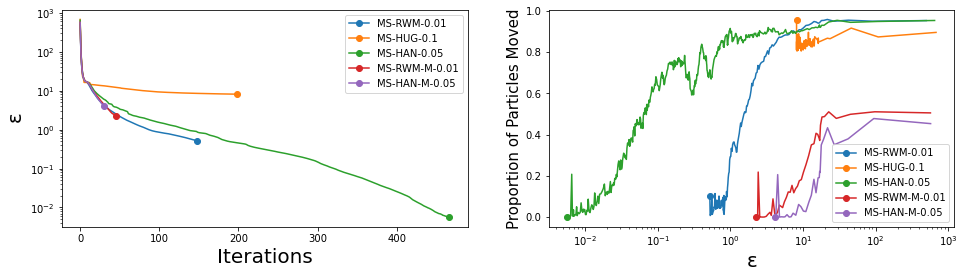

In [175]:
# Don't show from the smallest epsilons, or it will be too much
starting_index = 2

fig, ax = plt.subplots(ncols=2, figsize=(16, 4))

# Epsilon / Iteration
# ax[0].plot(ms_rwm_01_05.εs[starting_index:], label='MS-RWM-0.1', marker='o', markevery=[-1])
ax[0].plot(ms_rwm_001_05.εs[starting_index:], label='MS-RWM-0.01', marker='o', markevery=[-1])
# ax[0].plot(ms_rwm_aδ_05.εs[starting_index:], label='MS-RWM-aδ', marker='o', markevery=[-1])
ax[0].plot(ms_hug_01_05.εs[starting_index:], label='MS-HUG-0.1', marker='o', markevery=[-1])
# ax[0].plot(epsilon_values[starting_index:], label='MS-HAN-001', marker='o', markevery=[-1])
ax[0].plot(ms_han_005_05.εs[starting_index:], label='MS-HAN-0.05', marker='o', markevery=[-1])
# ax[0].plot(ms_rh_001_05.εs[starting_index:], label='MS-RH-0.01', marker='o', markevery=[-1])
# ax[0].plot(ms_han_aδ_05_060.εs[starting_index:], label='MS-HAN-aδ06', marker='o', markevery=[-1])
# ax[0].plot(ms_han_aδ_05_020.εs[starting_index:], label='MS-HAN-aδ02', marker='o', markevery=[-1])
ax[0].plot(ms_rwm_001_05_metrop.εs[starting_index:], label='MS-RWM-M-0.01', marker='o', markevery=[-1])
ax[0].plot(ms_han_005_05_metrop.εs[starting_index:], label='MS-HAN-M-0.05', marker='o', markevery=[-1])
# ax[0].axvline(ms_rh_001_05.n_switch, color='black', ls='--')
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$\mathregular{\varepsilon}$', fontsize=20)
ax[0].set_xlabel("Iterations", fontsize=20)

# Acceptance Probability / Epsilon
# ax[1].plot(ms_rwm_01_05.εs[starting_index:], ms_rwm_01_05.PROP_MOVED[starting_index:], label='MS-RWM-0.1', marker='o', markevery=[-1])
ax[1].plot(ms_rwm_001_05.εs[starting_index:], ms_rwm_001_05.PROP_MOVED[starting_index:], label='MS-RWM-0.01', marker='o', markevery=[-1])
# ax[1].plot(ms_rwm_aδ_05.εs[starting_index:], ms_rwm_aδ_05.PROP_MOVED[starting_index:], label='MS-RWM-aδ', marker='o', markevery=[-1])
ax[1].plot(ms_hug_01_05.εs[starting_index:], ms_hug_01_05.PROP_MOVED[starting_index:], label='MS-HUG-0.1', marker='o', markevery=[-1])
# ax[1].plot(epsilon_values[starting_index:], prop_moved[starting_index:], label='MS-HAN-001', marker='o', markevery=[-1])
ax[1].plot(ms_han_005_05.εs[starting_index:], ms_han_005_05.PROP_MOVED[starting_index:], label='MS-HAN-0.05', marker='o', markevery=[-1])
# ax[1].plot(ms_rh_001_05.εs[starting_index:], ms_rh_001_05.PROP_MOVED[starting_index:], label='MS-RH-0.01', marker='o', markevery=[-1])
# ax[1].plot(ms_han_aδ_05_060.εs[starting_index:], ms_han_aδ_05_060.PROP_MOVED[starting_index:], label='MS-HAN-aδ06', marker='o', markevery=[-1])
# ax[1].plot(ms_han_aδ_05_020.εs[starting_index:], ms_han_aδ_05_020.PROP_MOVED[starting_index:], label='MS-HAN-aδ02', marker='o', markevery=[-1])
ax[1].plot(ms_rwm_001_05_metrop.εs[starting_index:], ms_rwm_001_05_metrop.PROP_MOVED[starting_index:], label='MS-RWM-M-0.01', marker='o', markevery=[-1])
ax[1].plot(ms_han_005_05_metrop.εs[starting_index:], ms_han_005_05_metrop.PROP_MOVED[starting_index:], label='MS-HAN-M-0.05', marker='o', markevery=[-1])
ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$\mathregular{\varepsilon}$', fontsize=20)
ax[1].set_ylabel("Proportion of Particles Moved", fontsize=15)

plt.show()

# Indeces

In [110]:
def plot_histogram(n):
    fig, ax = plt.subplots(figsize=(20, 4))
    B = 20
    bins = np.arange(start=-0.5, stop=(B+1), step=1)
    _ = ax.hist(ms_han_005_05.K_RESAMPLED[n, :], bins=bins, density=True, edgecolor='k', color='lightsalmon')
    ax.set_xticks(np.arange(B+1))
    return plt.show()

resetwarnings()
interact(plot_histogram, n=(0, len(ms_han_005_05.ϵs) - 2))

interactive(children=(IntSlider(value=233, description='n', max=467), Output()), _dom_classes=('widget-interac…

<function __main__.plot_histogram(n)>

In [111]:
def plot_histogram(n):
    fig, ax = plt.subplots(figsize=(20, 4))
    B = 20
    bins = np.arange(start=-0.5, stop=(B+1), step=1)
    _ = ax.hist(ms_rh_001_05.K_RESAMPLED[n, :], bins=bins, density=True, edgecolor='k', color='lightsalmon')
    ax.set_xticks(np.arange(B+1))
    return plt.show()

resetwarnings()
interact(plot_histogram, n=(0, len(ms_rh_001_05.ϵs) - 2))

interactive(children=(IntSlider(value=188, description='n', max=377), Output()), _dom_classes=('widget-interac…

<function __main__.plot_histogram(n)>

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])